# drosophila_simulation

> Create initial conditions for a "germ band", and run simulations with patterned mechanical feedback.

Having defined mesh data structure, tension triangulation time evolution and primal cell shape optimization, we  now turn to the specific type of simulation we want to run: idealized versions of the _Drosophila_ "germ band".

We show how to create the required initial conditions, add some more helper functions for intercalation handling, and examples of how to analyze a simulation, building on the `02_delaunay_simulation` notebook.

In [ ]:
#| default_exp drosophila

In [ ]:
#| hide
from nbdev.showdoc import *
import nbdev

In [ ]:
#| export
import CE_simulation.mesh as msh
import CE_simulation.tension as tns
import CE_simulation.delaunay as dln
import CE_simulation.isogonal as iso

In [ ]:
#| export
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy import optimize

from tqdm.notebook import tqdm

from copy import deepcopy
import pickle

In [ ]:
#| export

from typing import Union, Dict, List, Tuple, Iterable, Callable, Any
from nptyping import NDArray, Int, Float, Shape

from fastcore.foundation import patch

In [ ]:
#| export

import jax.numpy as jnp
from jax import grad as jgrad
from jax import jit
from jax.tree_util import Partial

from jax.config import config
config.update("jax_enable_x64", True) # 32 bit leads the optimizer to complain about precision loss
config.update("jax_debug_nans", False) # useful for debugging, but makes code slower!

In [ ]:
#| export

import ipywidgets as widgets
from matplotlib import animation, rc

In [ ]:
#| notest

import importlib

## Initial condition creation

In notebook `02_delaunay_simulation` we have already seen how to create some initial conditions, based on triangular lattice patches. However, in the simulations we wish to carry out, we need to specify some more data:

- Boundary conditions
- Active and passive regions
- Plotting helpers, e.g. initial row of each cell

We present and additional routine for initial condition creation, more specific to the _Drosophila_ germ band simulations we plan to carry out.  

In [ ]:
## colors for cell rows

fridtjof_colors = np.array([[0.34398, 0.49112, 0.89936],
                            [0.97, 0.606, 0.081],
                            [0.91, 0.318, 0.243],
                            [0.448, 0.69232, 0.1538],
                            [0.62168, 0.2798, 0.6914],
                            [0.09096, 0.6296, 0.85532],
                            [0.46056, 0.40064, 0.81392],
                            [0.94, 0.462, 0.162],
                            [0., 0.7, 0.7],
                            [0.827051, 0.418034, 0.0243459],
                            [0.5511749434976025, 0.32014794962639853, 0.8720626412559938],
                            [0.72694101250947, 0.7196601125010522, 0.],
                            [0.8680706456216862, 0.2563858708756628, 0.30321559063052295],
                            [0.2418693812442152, 0.5065044950046278, 0.9902432574930582],
                            [0.9573908706237908, 0.5369543531189542, 0.11504464931576472]])

In [ ]:
#| export

def create_rect_initial(nx, ny, noise=0, initial_strain=0, isogonal=0, orientation='orthogonal',
                        boundaries=None, w_passive=0, bdry_x=None, bdry_y=None,
                        random_seed=0):
    """
    Create initial condition for germ band simulations.
    
    Creates a HalfEdgeMesh from a rectangulat patch of triangular lattice, creates boundary conditions,
    selects active and passive triangles, creates a dictionary with the initial rows of active cells,
    and sets edge rest lengths and cell rest shapes.
    
    Random seed for noise can be specified for reproducible results.
    
    Parameters
    ----------
    nx, ny: int
        Width and height of rectangular patch
    noise: float
        Standard deviation of the noise added to the initial vertex positions
    initial_strain: float
        Initial y-axis strain applied to tension triangulation. Applies transform matrix
        diag(1/(1+s), 1+s)
    orientation: 'orthogonal' or 'parallel'
        Orientation of hexagonal lattice direction w.r.t. y-axis.
    boundaries: list of 'top', 'bottom', 'left', 'right'
        On which sides to add slip walls.
    w_passive: float
        Width of passive region on the top and bottom
    bdry_x, bdry_y: float
        Location of the the left/right and top/bottom slip walls. If None, set to initial mesh positions
    random_seed: int
        Numpy random number generator seed.
        
    """
    np.random.seed(random_seed)
    # create the mesh
    if orientation == 'parallel':
        nx, ny = (ny, nx)
    mesh_initial = dln.create_rect_mesh(ny, nx, noise=noise, defects=(0, 0), straight_bdry=False)
    if orientation == 'orthogonal':
        mesh_initial.transform_vertices(dln.rot_mat(np.pi/2))
    center = np.mean([v.coords for v in mesh_initial.vertices.values()], axis=0)
    mesh_initial.transform_vertices(lambda x: x-center)
    mesh_initial.set_voronoi()
    
    mesh_initial.transform_vertices(dln.shear_mat(1+initial_strain))
    mesh_initial.set_rest_lengths()
    
    # create the boundary conditions
    boundaries = [] if boundaries is None else boundaries
    bdry_list = []
    max_x_cells = np.max([v.get_centroid()[0] for v in mesh_initial.vertices.values() if not v.is_bdry()])
    max_y_cells = np.max([v.get_centroid()[1] for v in mesh_initial.vertices.values() if not v.is_bdry()])

    bdry_x = np.ceil(max_x_cells) if bdry_x is None else bdry_x
    bdry_y = np.ceil(max_y_cells) if bdry_y is None else bdry_y
    
    w_bdry = .4
    
    if 'top' in boundaries:
        top_ids = []
        for v in mesh_initial.vertices.values():
            if (v.get_centroid()[1] > (max_y_cells-w_bdry)) and (not v.is_bdry()):
                top_ids.append(v._vid)
        def top_penalty(x):
            return (x[1]-bdry_y)**2
        top_penalty = Partial(jit(top_penalty))
        bdry_list.append([top_penalty, top_ids])

    if 'bottom' in boundaries:
        bottom_ids = []
        for v in mesh_initial.vertices.values():
            if (v.get_centroid()[1] < -(max_y_cells-w_bdry)) and (not v.is_bdry()):
                bottom_ids.append(v._vid)
        def bottom_penalty(x):
            return (x[1]+bdry_y)**2
        bottom_penalty = Partial(jit(bottom_penalty))
        bdry_list.append([bottom_penalty, bottom_ids])
        
    if 'left' in boundaries:
        left_ids = []
        for v in mesh_initial.vertices.values():
            if (v.get_centroid()[0] < -(max_x_cells-w_bdry)) and (not v.is_bdry()):
                left_ids.append(v._vid)
        def left_penalty(x):
            return (x[1]+bdry_x)**2
        left_penalty = Partial(jit(left_penalty))
        bdry_list.append([left_penalty, left_ids])

    if 'right' in boundaries:
        right_ids = []
        for v in mesh_initial.vertices.values():
            if (v.get_centroid()[0] > (max_x_cells-w_bdry)) and (not v.is_bdry()):
                right_ids.append(v._vid)
        def right_penalty(x):
            return (x[1]-bdry_x)**2
        right_penalty = Partial(jit(right_penalty))
        bdry_list.append([right_penalty, right_ids])

    # set the active and passive triangles
    passive_faces = []
    max_y_faces = np.max([val.dual_coords[1] for val in mesh_initial.faces.values()])
    for fc in mesh_initial.faces.values():
        if fc.is_bdry() or (np.abs(fc.dual_coords[1]) > (max_y_faces-w_passive)):
            passive_faces.append(fc._fid)
    passive_faces = sorted(passive_faces)
    passive_edges = msh.flatten([[he._heid for he in mesh_initial.faces[fc].hes] for fc in passive_faces])
    passive_cells = [v._vid for v in mesh_initial.vertices.values()
                     if not v.is_bdry() and any([fc._fid in passive_faces for fc in v.get_face_neighbors()])]

    # create dict of initial row ids
    if orientation == 'parallel':
        initial_row_dict = {key: np.round((2/np.sqrt(3))*val.get_centroid()[1]+.5, decimals=0)
                            for key, val in mesh_initial.vertices.items()
                            if (not key in passive_cells) and (not val.is_bdry())}
    elif orientation == 'orthogonal':
        initial_row_dict = {key: np.round(val.get_centroid()[1], decimals=0)
                            for key, val in mesh_initial.vertices.items()
                            if (not key in passive_cells) and (not val.is_bdry())}
    min_val = min(initial_row_dict.values())
    initial_row_dict = {key: int(val-min_val) for key, val in initial_row_dict.items()}
    
    # set isogonal mode for active cells.
    for v in mesh_initial.vertices.values():
        if v._vid in passive_cells:
            v.rest_shape = np.sqrt(3) * np.array([[1, 0],[0, 1]])
        else:
            v.rest_shape = np.sqrt(3) * np.array([[1-isogonal, 0],[0, 1+isogonal]])

    property_dict = {'initial_row_dict': initial_row_dict, 'passive_faces': passive_faces,
                     'passive_edges': passive_edges, 'passive_cells': passive_cells,
                     'bdry_x': bdry_x, 'bdry_y': bdry_y}
    
    return mesh_initial, bdry_list, property_dict

(-9.5, 9.5)

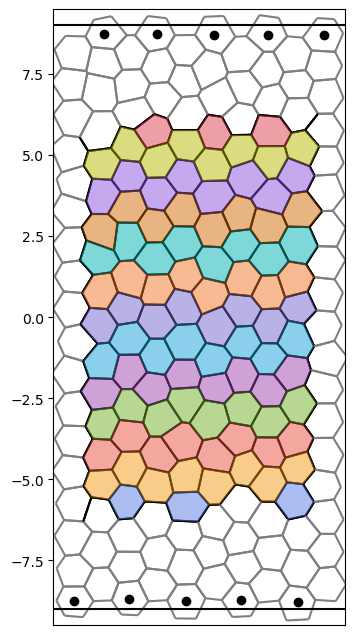

In [ ]:
## create and plot the initial condition

mesh_initial, bdry_list, property_dict = create_rect_initial(12, 20, noise=0.1, initial_strain=0.15,
                                                             orientation='orthogonal',
                                                             boundaries=['top', 'bottom'],
                                                             w_passive=3)

# set colors for edges and cells
edge_colors = {key: "tab:grey" for key in property_dict['passive_edges']}
cell_alpha = .5
cell_colors = {key: np.hstack([fridtjof_colors[val % fridtjof_colors.shape[0]], [cell_alpha]])
               for key, val in property_dict['initial_row_dict'].items()}

fig = plt.figure(figsize=(8,8))

mesh_initial.cellplot(edge_colors=edge_colors, cell_colors=cell_colors)
#mesh_initial.triplot()
#mesh_initial.labelplot()

# add line to visualize the slip boundary
bdry_x, bdry_y = (property_dict['bdry_x'], property_dict['bdry_y'])
plt.hlines((bdry_y, -bdry_y), (-7, -7), (7, 7), color="k")
for key in bdry_list[0][1]+bdry_list[1][1]:
    plt.scatter(*mesh_initial.vertices[key].get_centroid(), c="k")

plt.gca().set_aspect("equal", adjustable="box");
plt.xticks([],[])
#plt.yticks([],[])
plt.xlim([-bdry_x-.5, bdry_x+.5])
plt.ylim([-bdry_y-.5, bdry_y+.5])

#plt.savefig("plots/initial_cond.pdf")

### Intercalation handling

Handling intercalations is a bit more complicated than in the Delaunay case. Here, we define some helper functions.

In [ ]:
#| export

def rotate_about_center(x: NDArray[Shape["*,2"],Float], angle=np.pi/2):
    """
    Rotate points about center of mass. x.shape = (n_pts, 2).
    
    Used to rotate vertex positions post T1 to get a better new initial condition.
    """
    center = np.mean(x, axis=0)
    return (x-center)@dln.rot_mat(angle)+center

@patch
def get_flip_edge(self: msh.HalfEdgeMesh, minimal_l: float, exclude: List) -> Union[int, None]:
    """
    Gey key of the shortest primal edge in mesh if length < minimal_l and key not in exclude, else None.
    """
    
    primal_lengths = self.get_primal_edge_lens(oriented=True)
    primal_lengths = sorted(primal_lengths.items(), key=lambda x: x[1])
    primal_lengths = [x for x in primal_lengths if (x[1] <= minimal_l)]
    primal_lengths = [x for x in primal_lengths if not x[0] in exclude]
    if primal_lengths:
        return primal_lengths[0][0]
    return None

## Simulation with boundary conditions and passive & active cells

For starters, simply divide the cells into active $m=4$ and passive, $m=1$. Might be better to make this more gradual. 

### Plot initial condition

In [ ]:
#| notest
%matplotlib inline

In [ ]:
## create and plot the initial condition

mesh_initial, bdry_list, property_dict = create_rect_initial(14, 20, noise=0.1, initial_strain=0.15,
                                                             orientation='orthogonal', isogonal=.1,
                                                             boundaries=['top', 'bottom'],
                                                             w_passive=4)

(-9.5, 9.5)

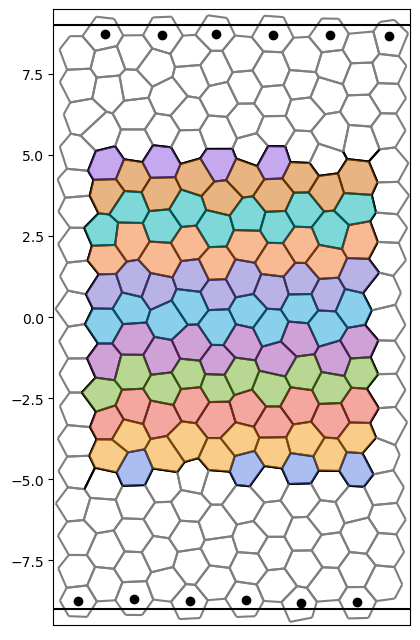

In [ ]:
# set colors for edges and cells
edge_colors = {key: "tab:grey" for key in property_dict['passive_edges']}
cell_alpha = .5
cell_colors = {key: np.hstack([fridtjof_colors[val % fridtjof_colors.shape[0]], [cell_alpha]])
               for key, val in property_dict['initial_row_dict'].items()}

fig = plt.figure(figsize=(8,8))

mesh_initial.cellplot(edge_colors=edge_colors, cell_colors=cell_colors)
#mesh_initial.triplot()
#mesh_initial.labelplot()

# add line to visualize the slip boundary
bdry_x, bdry_y = (property_dict['bdry_x'], property_dict['bdry_y'])
plt.hlines((bdry_y, -bdry_y), (-7, -7), (7, 7), color="k")
for key in bdry_list[0][1]+bdry_list[1][1]:
    plt.scatter(*mesh_initial.vertices[key].get_centroid(), c="k")

plt.gca().set_aspect("equal", adjustable="box");
plt.xticks([],[])
#plt.yticks([],[])
plt.xlim([-bdry_x-.5, bdry_x+.5])
plt.ylim([-bdry_y-.5, bdry_y+.5])

#plt.savefig("plots/initial_cond.pdf")

## set simulation parameters

In [ ]:
property_dict.keys()

dict_keys(['initial_row_dict', 'passive_faces', 'passive_edges', 'passive_cells', 'bdry_x', 'bdry_y'])

In [ ]:
## feedback parameters

m = 4
k = .5
k_cutoff = .1 # regularization term
 
passive_ids = property_dict['passive_faces']
def params_pattern(fid):
    if fid in passive_ids:
        return {"k": .25, "m": 1} # lower k here makes the passive region less lattice-like
    # might add an extra case for the edges in slip-wall boundary cells
    return {"k": k, "m": 4, "k_cutoff": k_cutoff}

params_no_pattern = {"k": k, "m": m, "k_cutoff": k_cutoff}
    
dt = .001 # time step
n_steps = 100
forbid_reflip = 20
minimal_l = .075 # minimal edge length, lower edge lengths trigger T1

tri_mod_area = .01 # triangle area regularization

In [ ]:
## cell shape parameters

tol, maxiter = (1e-4, 10000)
mod_bulk = 1
mod_shear = .5
angle_penalty = 1000
bdry_penalty = 5000

epsilon_l = 1e-3

A0 = jnp.sqrt(3)/2
mod_area = 0

bdr_weight = 2

passive_cells = property_dict['passive_cells']
rel_elastic_modulus = .8 # reduction in elastic modulus in passive cells
cell_id_to_modulus = np.vectorize(lambda x: 1-rel_elastic_modulus*(x in passive_cells))

energy_args = {"mod_bulk": mod_bulk, "mod_shear": mod_shear,
               "angle_penalty": angle_penalty, "bdry_penalty": bdry_penalty, "epsilon_l": epsilon_l,
               "A0": A0, "mod_area": mod_area}

use_voronoi = False # don't do shape optimization, run voronoi instead

In [ ]:
## rest length relaxation

k_rest = 0

def rhs_rest_shape(v):
    """Rest shape relaxation but do not relax area, i.e. trace. Also, only relax passive cells"""
    #if v._vid in passive_cells:
    #    delta = v.rest_shape-v.get_shape_tensor()
    #    return -k_rest*(delta - np.trace(delta)/2 * np.eye(2))
    #else:
    #    return 0
    delta = v.rest_shape-v.get_vrtx_shape_tensor()
    return -k_rest*(delta - np.trace(delta)/2 * np.eye(2))


## Simulation loop

Note: when saving, we need to save some additional data (the passive tensions and the cell rest shapes) which are not by default saved by the `HalfEdgeMesh` save routine. They are saved as dicts, so that after loading the properties can be set again, for example to continue simulating.

Few if any recompilations during simulation run according to `get_E._cache_size(), get_E_jac._cache_size()`

In [ ]:
meshes = [deepcopy(mesh_initial)]
times = [0]
last_flipped_edges = [[]] # T1_count = np.cumsum([len(x) for x in last_flipped_edge])

In [ ]:
save = True
save_dir = "runs/germ_band_test"
try:
    os.mkdir(save_dir)
except FileExistsError:
    print('Warning: directory exists')

In [ ]:
## simulation loop

mesh = deepcopy(meshes[-1])
for i in tqdm(range(0, n_steps)):
    # euler step
    mesh.euler_step(dt=dt, rhs_tension=tns.excitable_dt_act_pass, params=params_pattern,
                    rhs_rest_shape=rhs_rest_shape)
    # flatten triangulation
    mesh.flatten_triangulation(mod_area=tri_mod_area, tol=1e-4)
    # primal optimization
    if use_voronoi:
        mesh.set_voronoi()
    else:
        mesh.optimize_cell_shape(bdry_list=bdry_list, energy_args=energy_args,
                                 cell_id_to_modulus=cell_id_to_modulus,
                                 tol=tol, maxiter=maxiter, verbose=True, bdr_weight=bdr_weight)
    # check for intercalation
    flipped = []
    failed_flip = []
    flip_edge = mesh.get_flip_edge(minimal_l, list(msh.flatten(last_flipped_edges[-forbid_reflip:])))
    while flip_edge is not None:
        try:
            print(f"flip {flip_edge}, tpt {i}")
            he = mesh.hes[flip_edge]
            mesh.flip_edge(flip_edge)
            mesh.reset_rest_passive_flip(he, method="smooth")
            f0, f1 = (he.face, he.twin.face)
            f0.dual_coords, f1.dual_coords = rotate_about_center(np.stack([f0.dual_coords, f1.dual_coords]))
            flipped.append(he._heid)
            if use_voronoi:
                mesh.set_voronoi()
            else:
                mesh.optimize_cell_shape(bdry_list=bdry_list, energy_args=energy_args,
                                         cell_id_to_modulus=cell_id_to_modulus,
                                         tol=tol, maxiter=maxiter, verbose=True)
            exclude = list(msh.flatten(last_flipped_edges[-forbid_reflip:]))+flipped+failed_flip
            flip_edge = mesh.get_flip_edge(minimal_l, exclude)
            
        except ValueError:
            print(f"failed flip {flip_edge}, tpt {i}")
            failed_flip.append(flip_edge)
            exclude = list(flatten(last_flipped_edges[-forbid_reflip:]))+flipped+failed_flip
            flip_edge = mesh.get_flip_edge(minimal_l, exclude)
            continue

    # rescale & reorient triangulation
    mesh.transform_vertices(dln.get_conformal_transform(meshes[-1], mesh))
    # log
    last_flipped_edges.append(flipped)
    meshes.append(deepcopy(mesh))
    times.append(times[-1]+dt)
    if save:
        mesh.save_mesh(f"{save_dir}/{str(i).zfill(4)}_mesh.txt")
        rest_dict = {key: val.rest_shape for key, val in mesh.vertices.items()}
        pickle.dump(rest_dict, open(f"{save_dir}/{str(i).zfill(4)}_rest_shape.p", "wb"))
        passive_dict = {key: val.passive for key, val in mesh.hes.items()}
        pickle.dump(passive_dict, open(f"{save_dir}/{str(i).zfill(4)}_passive.p", "wb"))
        # all other info should be contained in mesh

last_flipped_edges.append([])

  0%|          | 0/100 [00:00<?, ?it/s]

flip 1443, tpt 17
flip 1129, tpt 17
flip 1186, tpt 21
flip 135, tpt 25
flip 1116, tpt 26
flip 631, tpt 27
flip 469, tpt 28
flip 1173, tpt 29
flip 181, tpt 29
flip 886, tpt 29
flip 1138, tpt 31
flip 1009, tpt 33
flip 1240, tpt 38
flip 1227, tpt 40
flip 1177, tpt 40
flip 0, tpt 42
flip 975, tpt 43
flip 627, tpt 44
flip 175, tpt 45
flip 1387, tpt 46
flip 1380, tpt 46
flip 504, tpt 47
flip 148, tpt 49
flip 391, tpt 49
flip 1441, tpt 50
flip 1335, tpt 51
flip 852, tpt 52
flip 490, tpt 52
flip 1354, tpt 53
flip 1213, tpt 54
flip 219, tpt 54
flip 1455, tpt 56
flip 393, tpt 57
flip 424, tpt 57
flip 378, tpt 58
flip 1309, tpt 58
flip 850, tpt 60
flip 1114, tpt 60
flip 192, tpt 61
flip 318, tpt 62
flip 1324, tpt 62
flip 465, tpt 62
flip 472, tpt 62
flip 0, tpt 63
flip 990, tpt 63
flip 190, tpt 64
flip 343, tpt 65
flip 793, tpt 65
flip 1342, tpt 65
flip 1140, tpt 66
flip 1245, tpt 67
flip 19, tpt 68
flip 1419, tpt 69
flip 1368, tpt 69
flip 1350, tpt 69
flip 148, tpt 70
flip 931, tpt 70
flip 808, 

In [ ]:
meshes[-1].is_consistent()

# inconsistent mesh created!
# I flipped two edges of the same triangle in succession

### Loading a saved simulation

In [ ]:
## reload a mesh. need to reset rest lengths and shapes

dirname = 'germ_band_very_large_isogonal_no_bdry_script'

fnames  = [x for x in sorted(os.listdir(f'runs/{dirname}/')) if 'mesh' in x][::5]

meshes = [load_mesh(f'runs/{dirname}/{x}') for x in tqdm(fnames)]
[msh.set_rest_lengths() for msh in tqdm(meshes)];
#for msh in tqdm(meshes):
#    for v in msh.vertices.values():
#        v.rest_shape = sqrt(3) * np.array([[1-iso, 0],[0, 1+iso]])

for ix, msh in tqdm(enumerate(meshes)):
    rest_shapes = pickle.load(open(f'runs/{dirname}/{str(ix).zfill(4)}_rest_shape.p', 'rb'))
    passive = pickle.load(open(f'runs/{dirname}/{str(ix).zfill(4)}_passive.p', 'rb'))
    for key, val in msh.vertices.items():
        val.rest_shape = rest_shapes[key]
    for key, val in msh.hes.items():
        val.passive = passive[key]

### Analyze a simulation

In [ ]:
#| notest
%matplotlib inline

In [ ]:
# calculate the shape tensor energies

energies = [{key: val for key, val in msh.get_shape_energy(mod_bulk=mod_bulk, mod_shear=mod_shear).items()
             if val is not None} for msh in meshes]
angle_penalties = [msh.get_angle_deviation() for msh in meshes]

(0.0, 0.005)

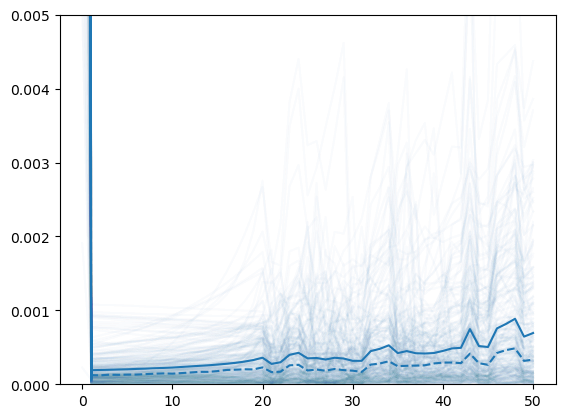

In [ ]:
# time series plot of angle penalties

a_time = np.array([[e[key] for e in angle_penalties] for key in angle_penalties[0].keys()])
plt.plot(a_time.T, color="tab:blue", alpha=.01);
plt.plot(np.mean(a_time, axis=0), color="tab:blue", alpha=1);
plt.plot(np.median(a_time, axis=0), color="tab:blue", alpha=1, ls="--");

plt.ylim([0, 5*1e-3])

(0.0, 1.0)

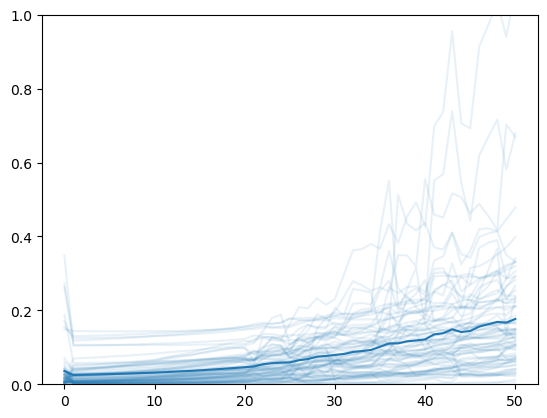

In [ ]:
# time series plot of energies

e_time = np.array([[e[key] for e in energies] for key in energies[0].keys()])
plt.plot(e_time.T, color="tab:blue", alpha=.1);
plt.plot(e_time.mean(axis=0), color="tab:blue", alpha=1);

plt.ylim([0, 10*1e-1])

<matplotlib.collections.PathCollection>

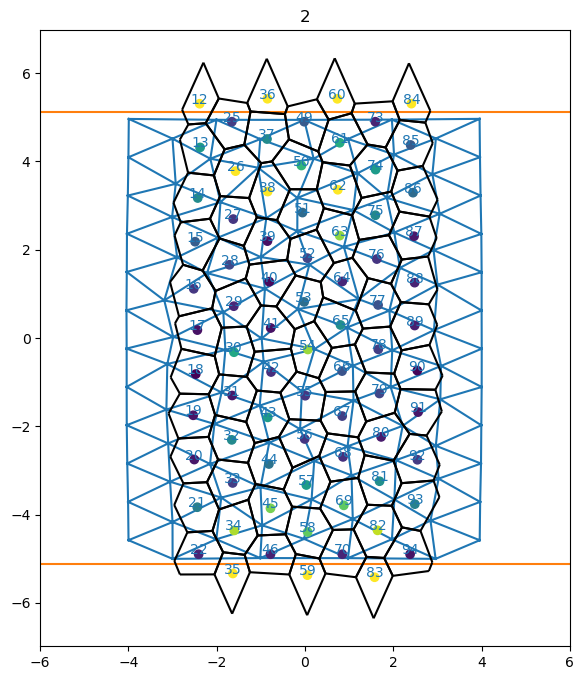

In [ ]:
# spatial plot of shape energies

i = 2

fig = plt.figure(figsize=(8,8))

plt.hlines((max_y_cells, -max_y_cells), (-7, -7), (7, 7), color="tab:orange")
plt.xlim([-6, 6])
#plt.ylim([-max_y-.5, max_y+.5])
plt.gca().set_aspect("equal", adjustable="box")
meshes[i].cellplot()
meshes[i].triplot()
meshes[i].labelplot(face_labels=False, cell_labels=True, vertex_labels=False)

plt.title(i);

# now calculate the energies and centroids
for_scttr = np.stack([np.hstack([np.mean([fc.dual_coords
                                  for fc in meshes[i].vertices[key].get_face_neighbors()], axis=0), [val]])
                     for key, val in energies[i].items()], axis=-1)

plt.scatter(*for_scttr[:2], c=for_scttr[2], vmin=0, vmax=5*1e-2)

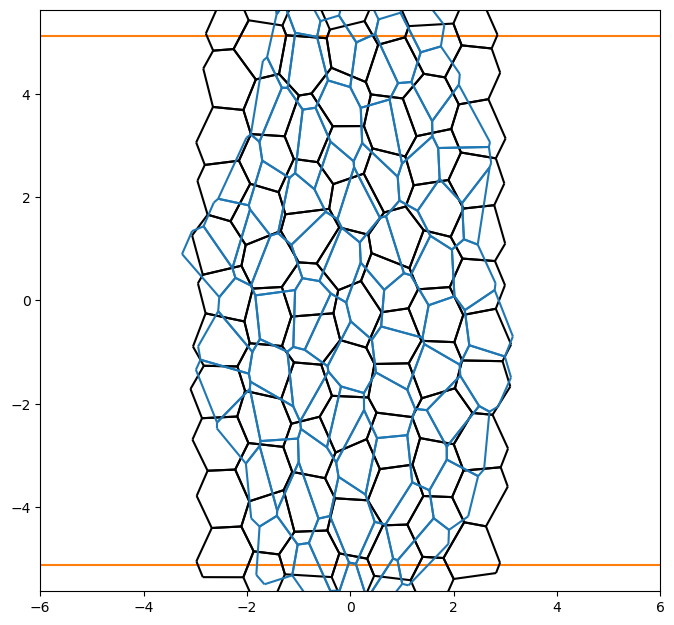

In [ ]:
fig = plt.figure(figsize=(8,8))

plt.hlines((max_y_cells, -max_y_cells), (-7, -7), (7, 7), color="tab:orange")
plt.xlim([-6, 6])
plt.gca().set_aspect("equal", adjustable="box")
meshes[1].cellplot()
meshes[-1].cellplot(edge_colors={he: "tab:blue" for he in meshes[-1].hes.keys()})


(0.0, 1.7320508075688772)

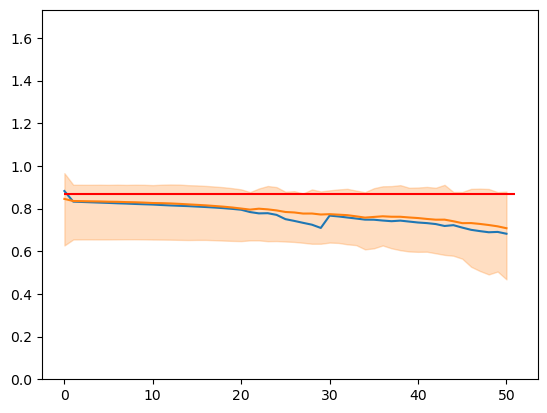

In [ ]:
# create a time-series of areas

areas = np.empty((len(meshes), len(meshes[0].vertices)))
for t, msh in enumerate(meshes):
    for v in msh.vertices.values():
        nghbs = v.get_face_neighbors()
        if (None in nghbs):
            areas[t, v._vid] = np.nan
        else: 
            areas[t, v._vid] = polygon_area(np.stack([fc.dual_coords for fc in nghbs]))
            
areas = areas[:, ~np.isnan(areas).any(axis=0)]

plt.plot(areas[:, 3])
mean = areas.mean(axis=1)

plt.plot(mean)
plt.fill_between(np.arange(areas.shape[0]), np.quantile(areas, .05, axis=1),
                 np.quantile(areas, .95, axis=1), color="tab:orange", alpha=.25)

plt.hlines(sqrt(3)/2, 0, len(meshes), color="r")
plt.ylim([0, sqrt(3)])


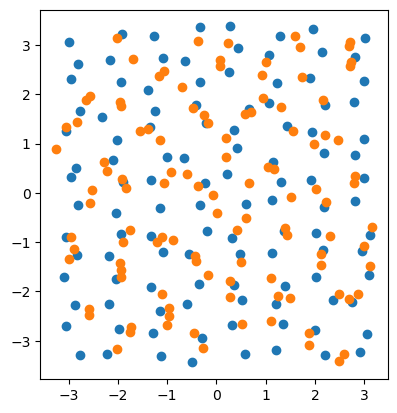

In [ ]:
# overlay initial and final positions of active cell vertices

initial = np.stack([meshes[1].faces[x].dual_coords for x in active_ids])
final = np.stack([meshes[-1].faces[x].dual_coords for x in active_ids])

plt.scatter(*initial.T)
plt.scatter(*final.T)

plt.gca().set_aspect("equal", adjustable="box")

In [ ]:
#| notest
%matplotlib inline

<IPython.core.display.Javascript object>


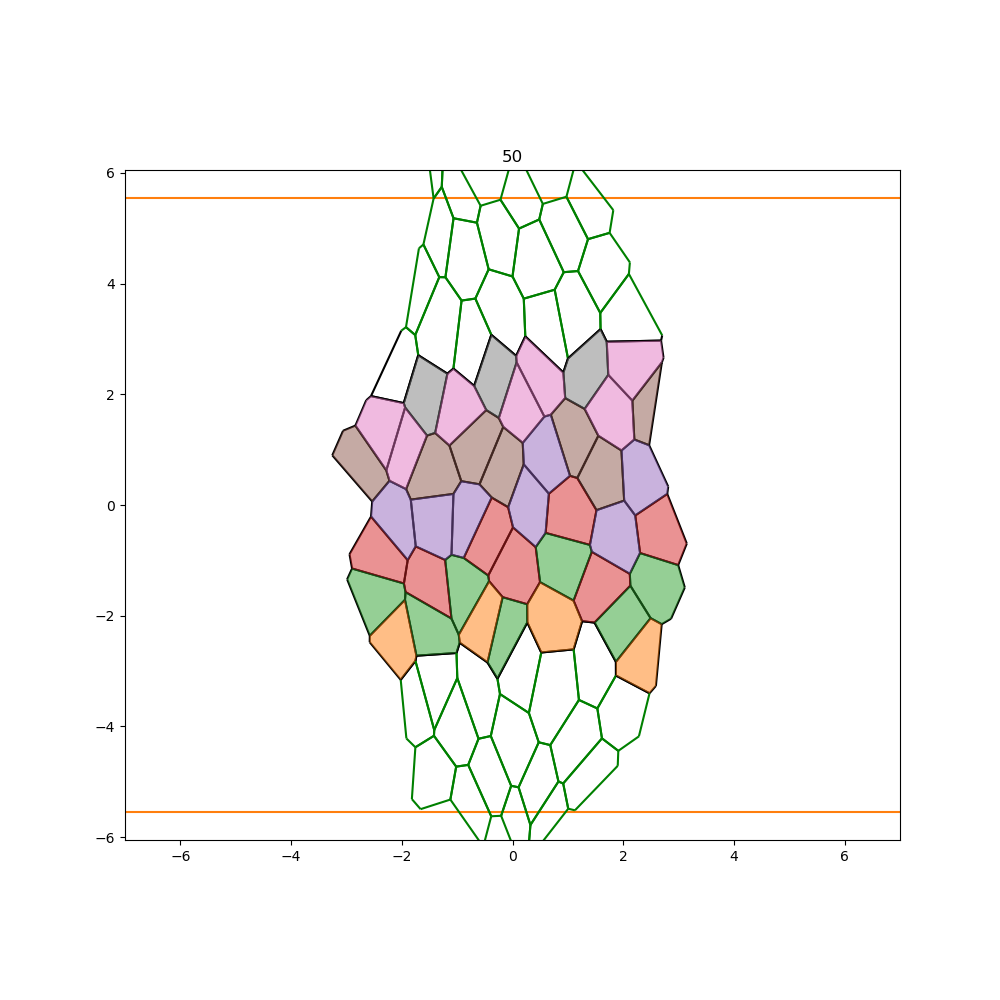

interactive(children=(IntSlider(value=25, description='i', max=50, min=1), Output()), _dom_classes=('widget-in…

In [ ]:
#| notest

# Slider plot

%matplotlib notebook

fig = plt.figure(figsize=(10, 10))

def plot_mesh(i):
    plt.cla()
    plt.hlines((max_y, -max_y), (-7, -7), (7, 7), color="tab:orange")
    plt.xlim([-7, 7])
    plt.ylim([-max_y-.5, max_y+.5])
    #plt.xlim([-2., 2])
    #plt.ylim([0, 4])
    plt.gca().set_aspect("equal", adjustable="box")
    meshes[i].cellplot(edge_colors=edge_colors, cell_colors=cell_colors)
    #meshes[i].labelplot(halfedge_labels=False, vertex_labels=True, face_labels=False)
    #meshes[i].triplot()
    plt.title(i)
    for x in last_flipped_edges[i+1]:
        he = meshes[i].hes[x]
        line = np.stack([he.vertices[0].coords, he.vertices[1].coords])
        #plt.plot(*line.T, c="tab:purple", lw=4)
        line = np.stack([he.face.dual_coords, he.twin.face.dual_coords])
        plt.plot(*line.T, c="r", lw=4)
widgets.interact(plot_mesh, i=(1, len(meshes)-1, 1));

In [ ]:
#| notest
%matplotlib inline


### Create and save an animation

In [ ]:
#| notest
%matplotlib inline

# Save simulation as HTML5 animation

# create the figure and axes objects
fig = plt.figure(facecolor="white", dpi=300)
nframes, frame_dt = n_steps, 500  # Delay between frames in milliseconds

def animate_meshes(n):
    n = n+1
    plt.cla()
    plt.hlines((max_y, -max_y), (-7, -7), (7, 7), color="tab:orange")
    plt.xlim([-7, 7])
    plt.ylim([-max_y-.5, max_y+.5])
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title('')
    meshes[n].cellplot(edge_colors=edge_colors, cell_colors=cell_colors)
    #meshes[n].triplot()
    for x in last_flipped_edges[n+1]:
        he = meshes[n].hes[x]
        line = np.stack([he.vertices[0].coords, he.vertices[1].coords])
        #plt.plot(*line.T, c="tab:purple", lw=2)
        line = np.stack([he.face.dual_coords, he.twin.face.dual_coords])
        plt.plot(*line.T, c="r", lw=2)
    if n == nframes-1:
        plt.close()

# run the animation
anim = animation.FuncAnimation(fig, animate_meshes, frames=nframes-1, interval=frame_dt, repeat=False)
anim.save('plots/germ_band_small_orth.mp4', fps=4,)
# maybe best to start from 1